## Telco

## Function Stuff

#### Pull Data Function (CSV or SQL with personal env file)

In [1]:
import os
import pandas as pd
from env import db_url

def get_telco_data():
    """
    This function retrieves the telco data from a CSV file if it exists,
    otherwise it retrieves the data from a SQL database and saves it to a CSV file.
    This function assumes the user has an env file formatted as:
    __________________________________________________
    user = "username"
    password = "password"
    host = "host"

    f"mysql+pymysql://{user}:{password}@{host}/{db}"
    __________________________________________________
    
    Args:
    - None

    Returns:
    - df: pandas dataframe containing the telco data
    """
    filename = "telco.csv"
    if os.path.isfile(filename):
        df = pd.read_csv(filename)
    else:
        query = """
        SELECT *
        FROM customers
        JOIN contract_types
        ON customers.contract_type_id = contract_types.contract_type_id
        JOIN internet_service_types
        ON customers.internet_service_type_id = internet_service_types.internet_service_type_id
        JOIN payment_types
        ON customers.payment_type_id = payment_types.payment_type_id;"""
        connection = db_url("telco_churn")
        df = pd.read_sql(query, connection)
        df.to_csv(filename, index=False)
    return df

#### Clean Function with Binary KWA (default=False)

In [2]:
from acquire import get_telco_data
import pandas as pd
import numpy as np

def prep_telco(df_telco, binary=False):
    # Drop the joiner columns from SQL and definitely useless columns
    df_telco = df_telco.drop(
        columns=[
            "internet_service_type_id",
            "contract_type_id",
            "payment_type_id",
            "contract_type_id.1",
            "internet_service_type_id.1",
            "payment_type_id.1",
        ]
    )
    # Fill NA in internet service type with what the rest of the table uses, 'No internet service'.
    df_telco["internet_service_type"].fillna("No internet service", inplace=True)
    
    # As we've noticed before, ['total_charges'] is detected as an object, but holds mainly numbers. We'll use pd.to_numeric() to force everything to a number,
    # and anything that it cannot convert, we'll make it Null and investigate those.
    df_telco["total_charges"] = pd.to_numeric(
        df_telco["total_charges"], errors="coerce"
    )
    # Total charges = 0 also has Tenure = 0. We'll assume they're new and haven't been charged
    df_telco["total_charges"].fillna(0, inplace=True)

    # Automatic payments could be important for churn, so we will separate it from the payment method
    df_telco["automatic_payments"] = (
        df_telco["payment_type"] == "Bank transfer (automatic)"
    ) | (df_telco["payment_type"] == "Credit card (automatic)")

    # Now that it is separated, we remove 'automatic_payment' from the payment types. Made casing uniform
    df_telco["payment_type"].replace(
        {
            "Electronic check": "electronic check",
            "Mailed check": "mailed check",
            "Credit card (automatic)": "credit card",
            "Bank transfer (automatic)": "bank transfer",
        },
        inplace=True,
    )

    # Change senior_citizen to Yes/No for better visuals
    df_telco["senior_citizen"].replace({0: "No", 1: "Yes"}, inplace=True)

    # Bin the tenure into groups of 12 to separate by year
    df_telco["tenure_years"] = df_telco["tenure"].apply(
        lambda x: int((x - 1) / 12) + 1
    )
    
    # Change from True / False to Yes / No for visuals and uniformity, also for tablewide binary conversion later
    df_telco["automatic_payments"].replace({False: "No", True: "Yes"}, inplace=True)

    # Create a total add ons that counts all of the add ons
    df_telco["total_add_ons"] = df_telco[
        [
            "phone_service",
            "online_security",
            "online_backup",
            "device_protection",
            "tech_support",
            "streaming_tv",
            "streaming_movies",
        ]
    ].apply(lambda x: (x == "Yes").sum(), axis=1)
    
    # Due to needing the customer_id later, we can't drop it. We'll assign it as
    # the index to keep it out of the way
    df_telco.set_index('customer_id', inplace=True)
    
    # Rename some columns 
    df_telco.rename(columns={'tenure': 'tenure_months',
                             'partner': 'married',
                             'dependents': 'kids',
                             }, inplace=True)

    if binary == False:
        return df_telco
    else:
        df_telco = telco_binary_normalized(df_telco)
        return df_telco

#### Good Information Collection Function for Dataframe

In [3]:
import pandas as pd

def check_columns(df):
    """
    This function takes a pandas dataframe as input and prints
    out information about each column in the dataframe. For 
    each column, it prints the column name, the number of
    unique values in the column, the unique values themselves,
    and the number of null values in the column.

    Args:
    - df: pandas dataframe

    Returns:
    - None
    """
    for column in df.columns:
        print(f"{column} ({df[column].nunique()})")
        print(f"Unique Values: {df[column].unique()}")
        print(f"Null Values: {df[column].isna().sum()}")
        print("")

#### Telco Binary Function

In [4]:
def telco_binary(df_telco):
    """
    This function takes in a pandas dataframe and returns
    a modified version of the dataframe with binary values
    for certain columns.

    Args:
    - df_telco: pandas dataframe

    Returns:
    - df_telco: pandas dataframe
    """
    # Replace values with binary values
    df_telco.replace({
        'No internet service': 0,
        'No phone service': 0,
        'No': 0,
        'Yes': 1,
        'Male': 1, 
        'Female': 0}, inplace=True)
    
    # 3 Categories (but we want to keep all 3)
    categorical = ['contract_type', 'payment_type', 'internet_service_type']

    # Get dummies for categorical columns
    cat = pd.get_dummies(df_telco[categorical], drop_first=False, dtype='int')

    # Drop redundant columns
    cat.drop(columns='internet_service_type_0', inplace=True)

    # Rename columns for uniformity
    cat.rename(columns={'contract_type_Month-to-month':'month_to_month_contract',
            'contract_type_One year':'one_year_contract',
            'contract_type_Two year':'two_year_contact',
            'payment_type_bank transfer':'bank_transfer_payment',
            'payment_type_credit card':'credit_card_payment', 
            'payment_type_electronic check':'e_check_payment',
            'payment_type_mailed check':'mailed_check_payment',
            'internet_service_type_DSL':'dsl_internet',
            'internet_service_type_Fiber optic':'fiber_optic_internet'}
        , inplace=True)

    # Concatenate the original dataframe with the categorical dataframe
    df_telco = pd.concat([df_telco, cat], axis=1)
    return df_telco

## Prepping Telco

In [5]:
# Get the data (CSV or pull from SQL with personal env file)

df_telco_full = get_telco_data()

In [6]:
# Clean the dataframe, optionally use binary=True to output the binary version. (Default is False)

# Use non-binary for better visualization
df_telco = prep_telco(df_telco_full)

In [7]:
df_telco.head()

,gender,senior_citizen,married,kids,tenure_months,phone_service,multiple_lines,online_security,online_backup,device_protection,...,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type,automatic_payments,tenure_years,total_add_ons
customer_id,,,,,,,,,,,,,,,,,,,,,
0002-ORFBO,Female,No,Yes,Yes,9,Yes,No,No,Yes,No,...,Yes,65.6,593.30,No,One year,DSL,mailed check,No,1,4
0003-MKNFE,Male,No,No,No,9,Yes,Yes,No,No,No,...,No,59.9,542.40,No,Month-to-month,DSL,mailed check,No,1,2
0004-TLHLJ,Male,No,No,No,4,Yes,No,No,No,Yes,...,Yes,73.9,280.85,Yes,Month-to-month,Fiber optic,electronic check,No,1,2
0011-IGKFF,Male,Yes,Yes,No,13,Yes,No,No,Yes,Yes,...,Yes,98.0,1237.85,Yes,Month-to-month,Fiber optic,electronic check,No,2,5
0013-EXCHZ,Female,Yes,Yes,No,3,Yes,No,No,No,No,...,Yes,83.9,267.40,Yes,Month-to-month,Fiber optic,mailed check,No,1,3


In [8]:
check_columns(df_telco)

gender (2)
Unique Values: ['Female' 'Male']
Null Values: 0

senior_citizen (2)
Unique Values: ['No' 'Yes']
Null Values: 0

married (2)
Unique Values: ['Yes' 'No']
Null Values: 0

kids (2)
Unique Values: ['Yes' 'No']
Null Values: 0

tenure_months (73)
Unique Values: [ 9  4 13  3 71 63  7 65 54 72  5 56 34  1 45 50 23 55 26 69 37 49 66 67
 20 43 59 12 27  2 25 29 14 35 64 39 40 11  6 30 70 57 58 16 32 33 10 21
 61 15 44 22 24 19 47 62 46 52  8 60 48 28 41 53 68 31 36 17 18 51 38 42
  0]
Null Values: 0

phone_service (2)
Unique Values: ['Yes' 'No']
Null Values: 0

multiple_lines (3)
Unique Values: ['No' 'Yes' 'No phone service']
Null Values: 0

online_security (3)
Unique Values: ['No' 'Yes' 'No internet service']
Null Values: 0

online_backup (3)
Unique Values: ['Yes' 'No' 'No internet service']
Null Values: 0

device_protection (3)
Unique Values: ['No' 'Yes' 'No internet service']
Null Values: 0

tech_support (3)
Unique Values: ['Yes' 'No' 'No internet service']
Null Values: 0

streaming

## Viz

<b> All of the visuals we use will be normalized. We'll normalize due to the dataset being imbalanced. </b>

<i>This is achieved by dividing the count of each value of the response variable by the total number of observations. The resulting values represent the proportion of observations that have each value of the response variable, and sum to 1. AKA proportions.

`sklearn`'s `mutual_info_score` is a function that computes the mutual information between two random variables. Mutual information is a measure of the amount of information that one random variable contains about another random variable. It is defined as the reduction in uncertainty about one variable given knowledge of the other variable.

In the context of machine learning, mutual information is often used as a feature selection method. It can be used to measure the dependence between a feature and the target variable, and can help identify features that are most relevant for predicting the target variable.

The `mutual_info_score` function takes two arrays as input, representing the two random variables, and returns the mutual information between them. The function can be used with both discrete and continuous variables, and can handle multiclass classification problems.

Note that mutual information is a symmetric measure, meaning that the mutual information between variable A and variable B is the same as the mutual information between variable B and variable A.

The mutual information extends the notion of correlation to nonlinear relationships since, unlike Pearson’s correlation coefficient, this method is able to detect not only linear relationships but also nonlinear ones.

- The Scikit-Learn library has implemented mutual information in the metrics package.

The mutual information score is a measure of the mutual dependence between two variables. It measures the amount of information that can be obtained about one variable by observing the other variable. 

In the context of feature selection, the mutual information score can be used to identify the categorical variables that are most strongly associated with the response variable (churn). The mutual information score is sensitive to both linear and non-linear relationships between the variables. This means that it can capture non-linear relationships between the categorical variables and the response variable, which may not be captured by other measures of association, such as correlation coefficients.

Therefore, the mutual information score is a useful measure for identifying important categorical variables that may have non-linear relationships with the response variable.

Mutual information — analysis of linear and nonlinear relationships

Mutual information measures the mutual dependency between two variables based on entropy estimations. In machine learning, we are interested in evaluating the degree of dependency between each independent variable and the response variable. Higher values of mutual information show a higher degree of dependency which indicates that the independent variable will be useful for predicting the target.

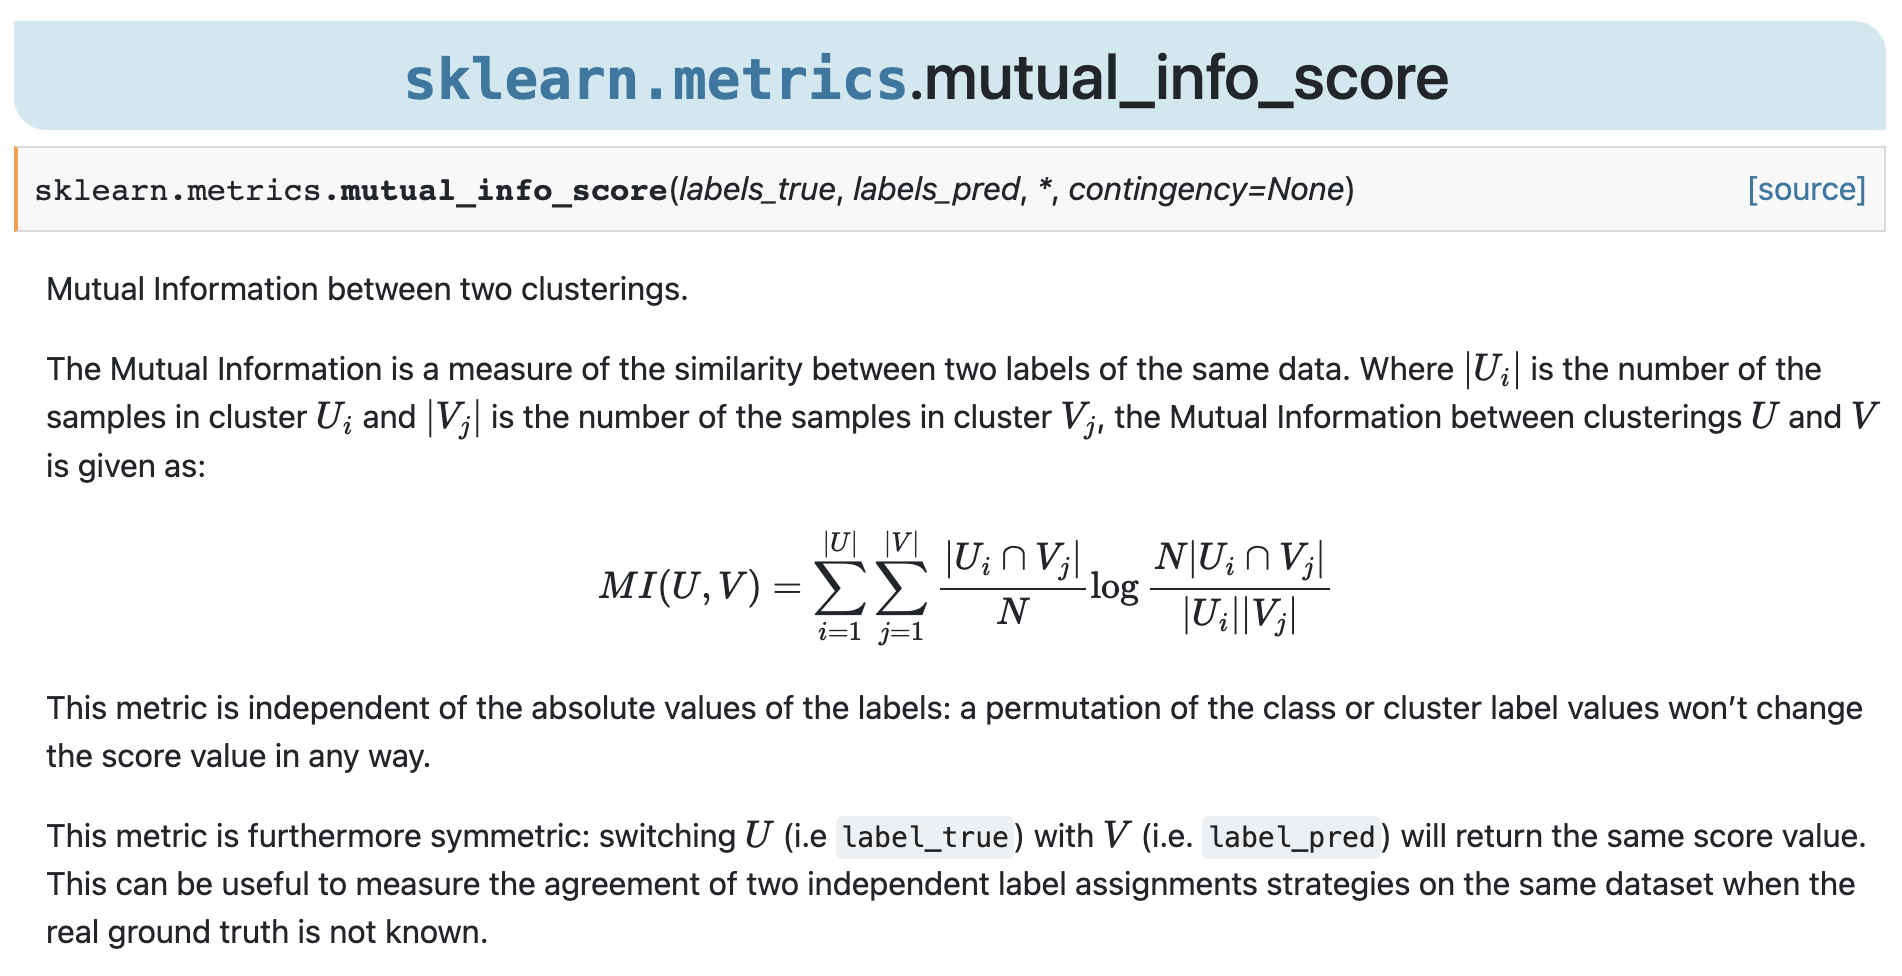

In [9]:
# The following code computes the mutual information score between each categorical 
# variable of the data set and the Churn variable.

from sklearn.metrics import mutual_info_score

def compute_mutual_information(categorical_series):
    return mutual_info_score(categorical_series, df_telco['churn'])

# select categorial variables excluding the response variable 
categorical_variables = df_telco.select_dtypes(include=object).drop('churn', axis=1)

# compute the mutual information score between each categorical variable and the target
feature_importance = categorical_variables.apply(compute_mutual_information).sort_values(ascending=False)

# visualize feature importance
print(feature_importance)

contract_type            0.098453
online_security          0.064677
tech_support             0.063021
internet_service_type    0.055574
online_backup            0.046792
payment_type             0.044519
device_protection        0.043917
streaming_movies         0.032001
streaming_tv             0.031908
automatic_payments       0.022886
paperless_billing        0.019194
kids                     0.014467
married                  0.011454
senior_citizen           0.010577
multiple_lines           0.000801
phone_service            0.000072
gender                   0.000037
dtype: float64


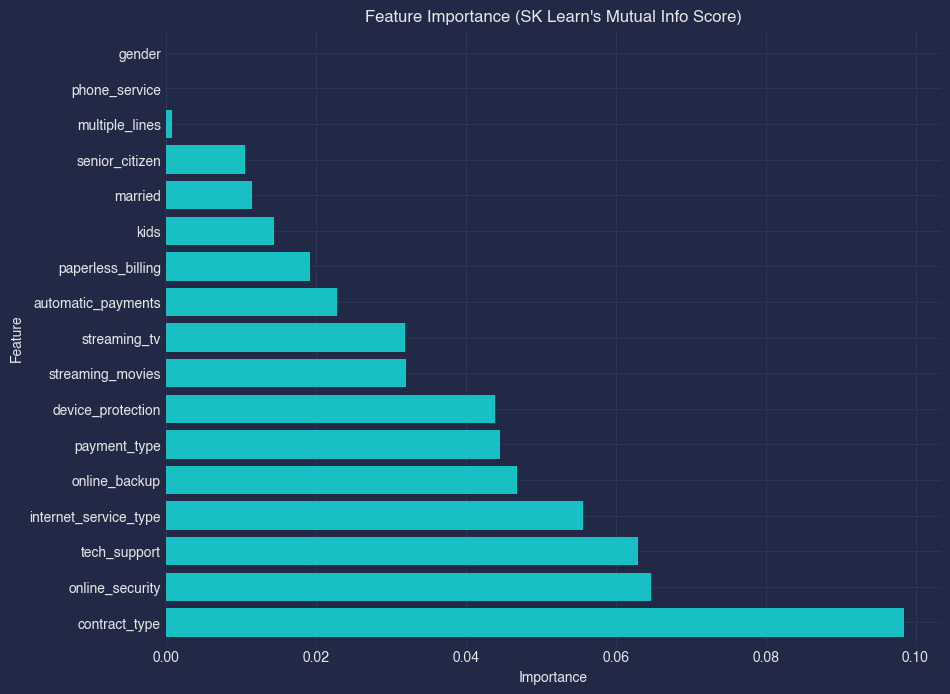

In [10]:
import matplotlib.pyplot as plt
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

feature_importance.sort_values(ascending=False)
ax = feature_importance.plot(kind='barh', figsize=(10,8), zorder=2, width=0.8)
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.set_title("Feature Importance (SK Learn's Mutual Info Score)")
plt.show()

- Gender, phone_service, and multiple_lines have a mutual information score really close to 0, meaning those variables do not have a strong relationship with the target. 

- This information is in line with the conclusions we have previously drawn by visualizing the data. In the following steps, we should consider removing those variables from the data set before training as they do not provide useful information for predicting the outcome.

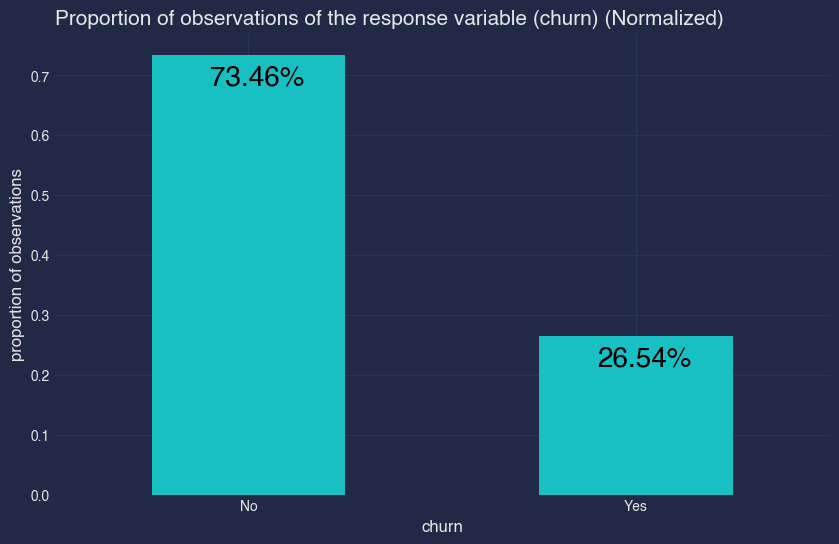

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# create a figure
fig = plt.figure(figsize=(10, 6)) 
ax = fig.add_subplot(111)

# proportion of churn
prop_response = df_telco['churn'].value_counts(normalize=True)

# bar plot showing the percentage of churn
prop_response.plot(kind='bar', 
                   ax=ax)

# add value counts to the top of each bar
for i, v in enumerate(prop_response):
    ax.text(i - 0.1, v - 0.05, str(round(v*100, 2)) + '%', fontsize=20, color='black')

# set labels and titles
ax.set_title('Proportion of observations of the response variable (churn) (Normalized)',
             fontsize=15, loc='left')
ax.set_xlabel('churn',
              fontsize=12)
ax.set_ylabel('proportion of observations',
              fontsize=12)
ax.tick_params(rotation='auto')


- This is an imbalanced data set.

- Both classes are not equally distributed among all observations, being 'No' the majority class (73.46%).

- When modeling, this imbalance will most likely lead to a large number of false negatives.

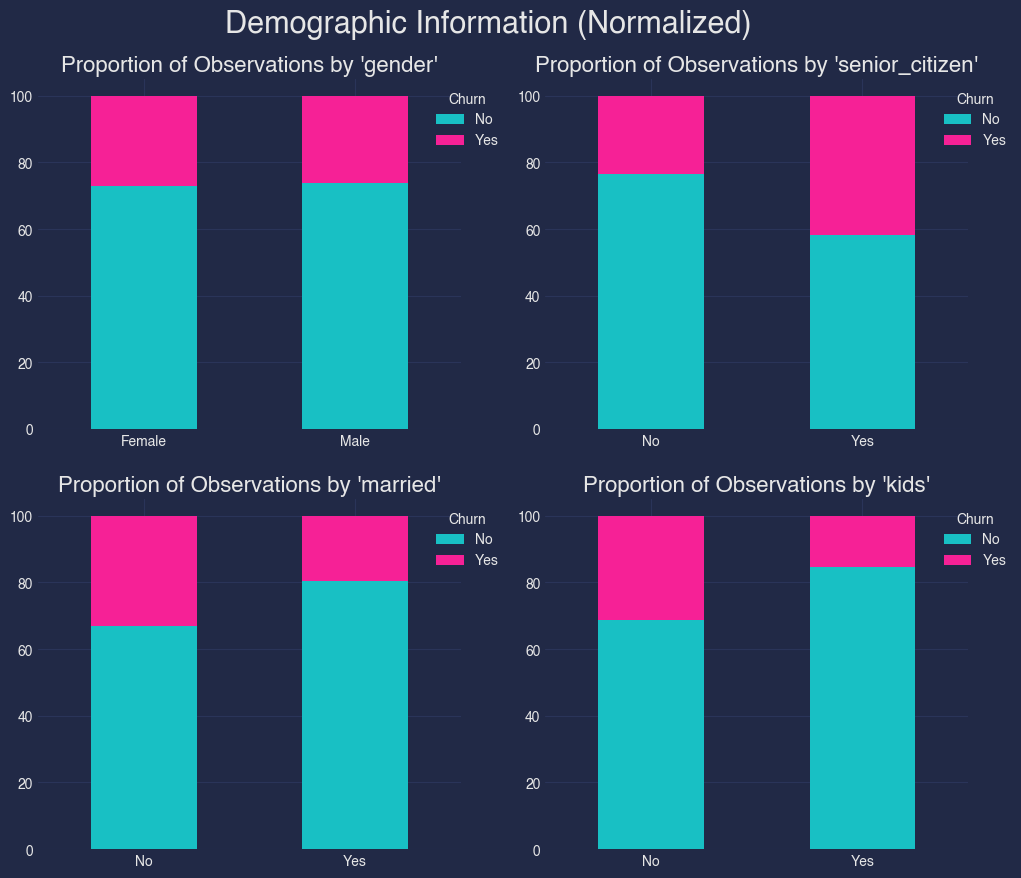

In [12]:
import math

def percentage_stacked_plot(columns_to_plot, super_title):
    
    '''
    Prints a 100% stacked plot of the response variable for independent variable of the list columns_to_plot.
            Parameters:
                    columns_to_plot (list of string): Names of the variables to plot
                    super_title (string): Super title of the visualization
            Returns:
                    None
    '''
    
    number_of_columns = 2
    number_of_rows = math.ceil(len(columns_to_plot)/2)

    # create a figure
    fig = plt.figure(figsize=(12, 5 * number_of_rows)) 
    fig.suptitle(super_title, fontsize=22,  y=.95)
 

    # loop to each column name to create a subplot
    for index, column in enumerate(columns_to_plot, 1):

        # create the subplot
        ax = fig.add_subplot(number_of_rows, number_of_columns, index)

        # calculate the percentage of observations of the response variable for each group of the independent variable
        # 100% stacked bar plot
        prop_by_independent = pd.crosstab(df_telco[column], df_telco['churn']).apply(lambda x: x/x.sum()*100, axis=1)

        prop_by_independent.plot(kind='bar', ax=ax, stacked=True,
                                 rot=0)

        # set the legend in the upper right corner
        ax.legend(loc="upper right", bbox_to_anchor=(0.62, 0.5, 0.5, 0.5),
                  title='Churn', fancybox=True)

        # set title and labels
        ax.set_title(f"Proportion of Observations by '{column}'",
                     fontsize=16, loc='center')

        ax.tick_params(rotation='auto')
        ax.set_xlabel('')

# demographic column names
demographic_columns = ['gender', 'senior_citizen', 'married', 'kids']

# stacked plot of demographic columns
percentage_stacked_plot(demographic_columns, 'Demographic Information (Normalized)')

- The churn rate of senior citizens is almost double that of young citizens.

- We do not expect gender to have significant predictive power. A similar percentage of churn is shown both when a customer is a man or a woman.

- Customers with a partner churn less than customers with no partner.

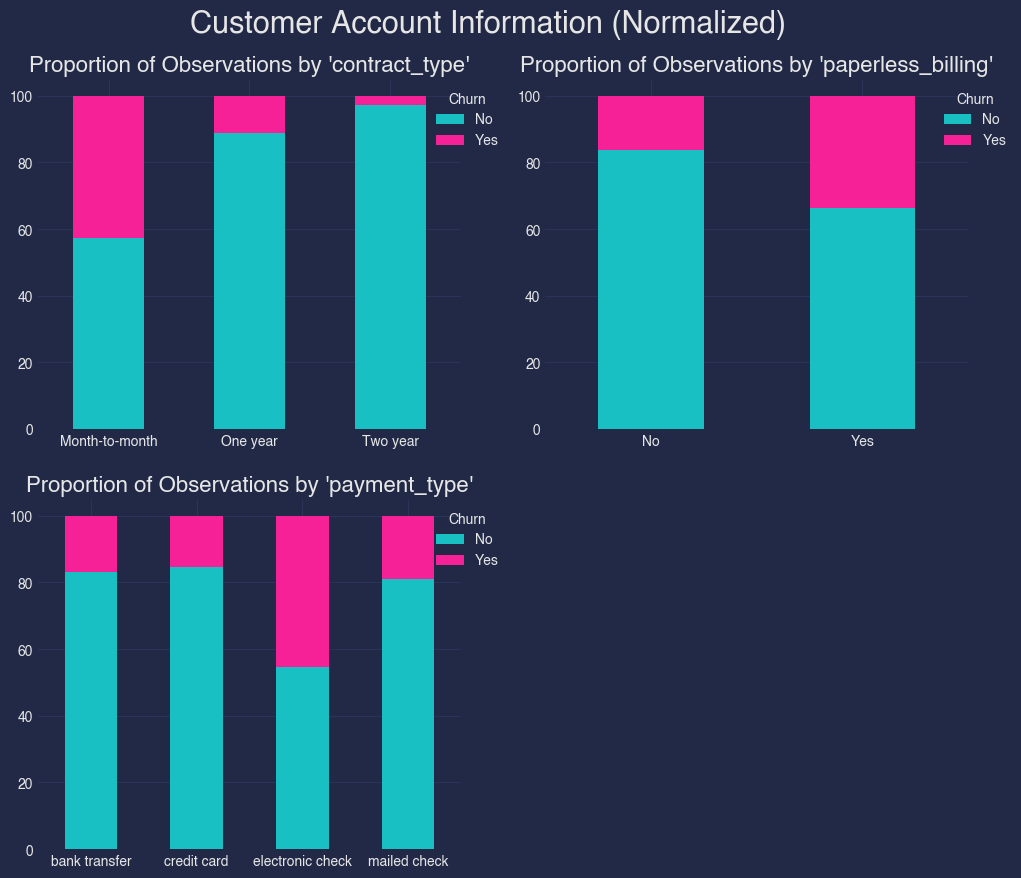

In [13]:
# Account Information
account_columns = ['contract_type', 'paperless_billing', 'payment_type']

# stacked plot of customer account columns
percentage_stacked_plot(account_columns, 'Customer Account Information (Normalized)')

- Customers with month-to-month contracts have higher churn rates compared to clients with yearly contracts.

- Customers who opted for an electronic check as paying method are more likely to leave the company.

- Customers subscribed to paperless billing churn more than those who are not subscribed.

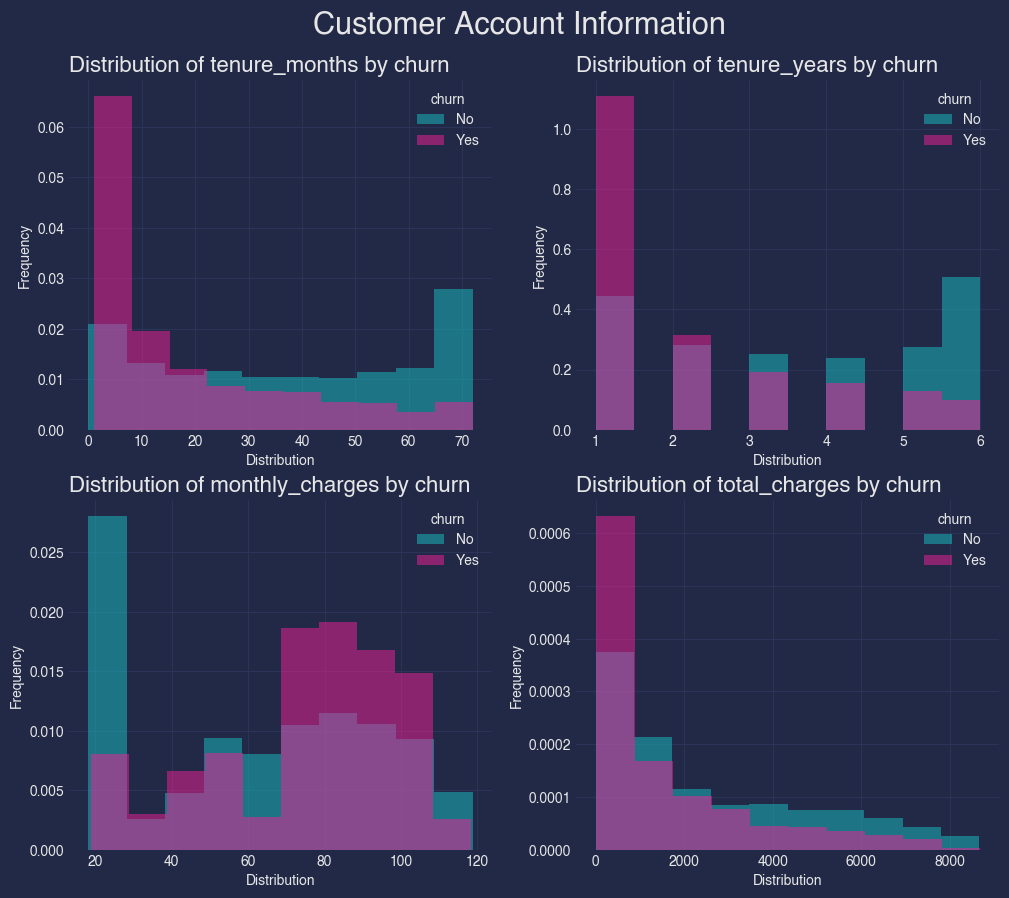

In [14]:
def histogram_plots(columns_to_plot, title):
    # set number of rows and number of columns
    column_number = 2
    row_number = math.ceil(len(columns_to_plot)/2)

    # create a figure
    fig = plt.figure(figsize=(12, 5 * row_number)) 
    fig.suptitle(title, fontsize=22,  y=.95)


    # loop to each demographic column name to create a subplot
    for index, column in enumerate(columns_to_plot, 1):

        # create the subplot
        ax = fig.add_subplot(row_number, column_number, index)

        # histograms for each class (normalized histogram)
        df_telco[df_telco['churn']=='No'][column].plot(kind='hist', ax=ax, density=True, 
                                                       alpha=0.5, label='No')
        df_telco[df_telco['churn']=='Yes'][column].plot(kind='hist', ax=ax, density=True,
                                                        alpha=0.5, label='Yes')
        
        # set the legend in the upper right corner
        ax.legend(loc="upper right", bbox_to_anchor=(0.5, 0.5, 0.5, 0.5),
                  title='churn', fancybox=True)

        # set title and labels
        ax.set_title('Distribution of ' + column + ' by churn',
                     fontsize=16, loc='left')
        ax.set_xlabel('Distribution')

        ax.tick_params(rotation='auto')
        
# customer account column names
account_columns_numeric = ['tenure_months','tenure_years', 'monthly_charges', 'total_charges']

# histogram of costumer account columns 
histogram_plots(account_columns_numeric, 'Customer Account Information')

- The churn rate tends to be larger when monthly charges are high.

- New customers (low tenure) are more likely to churn.

- Clients with high total charges are less likely to leave the company.

- If they stay at least 3 years, they're more likely to not churn

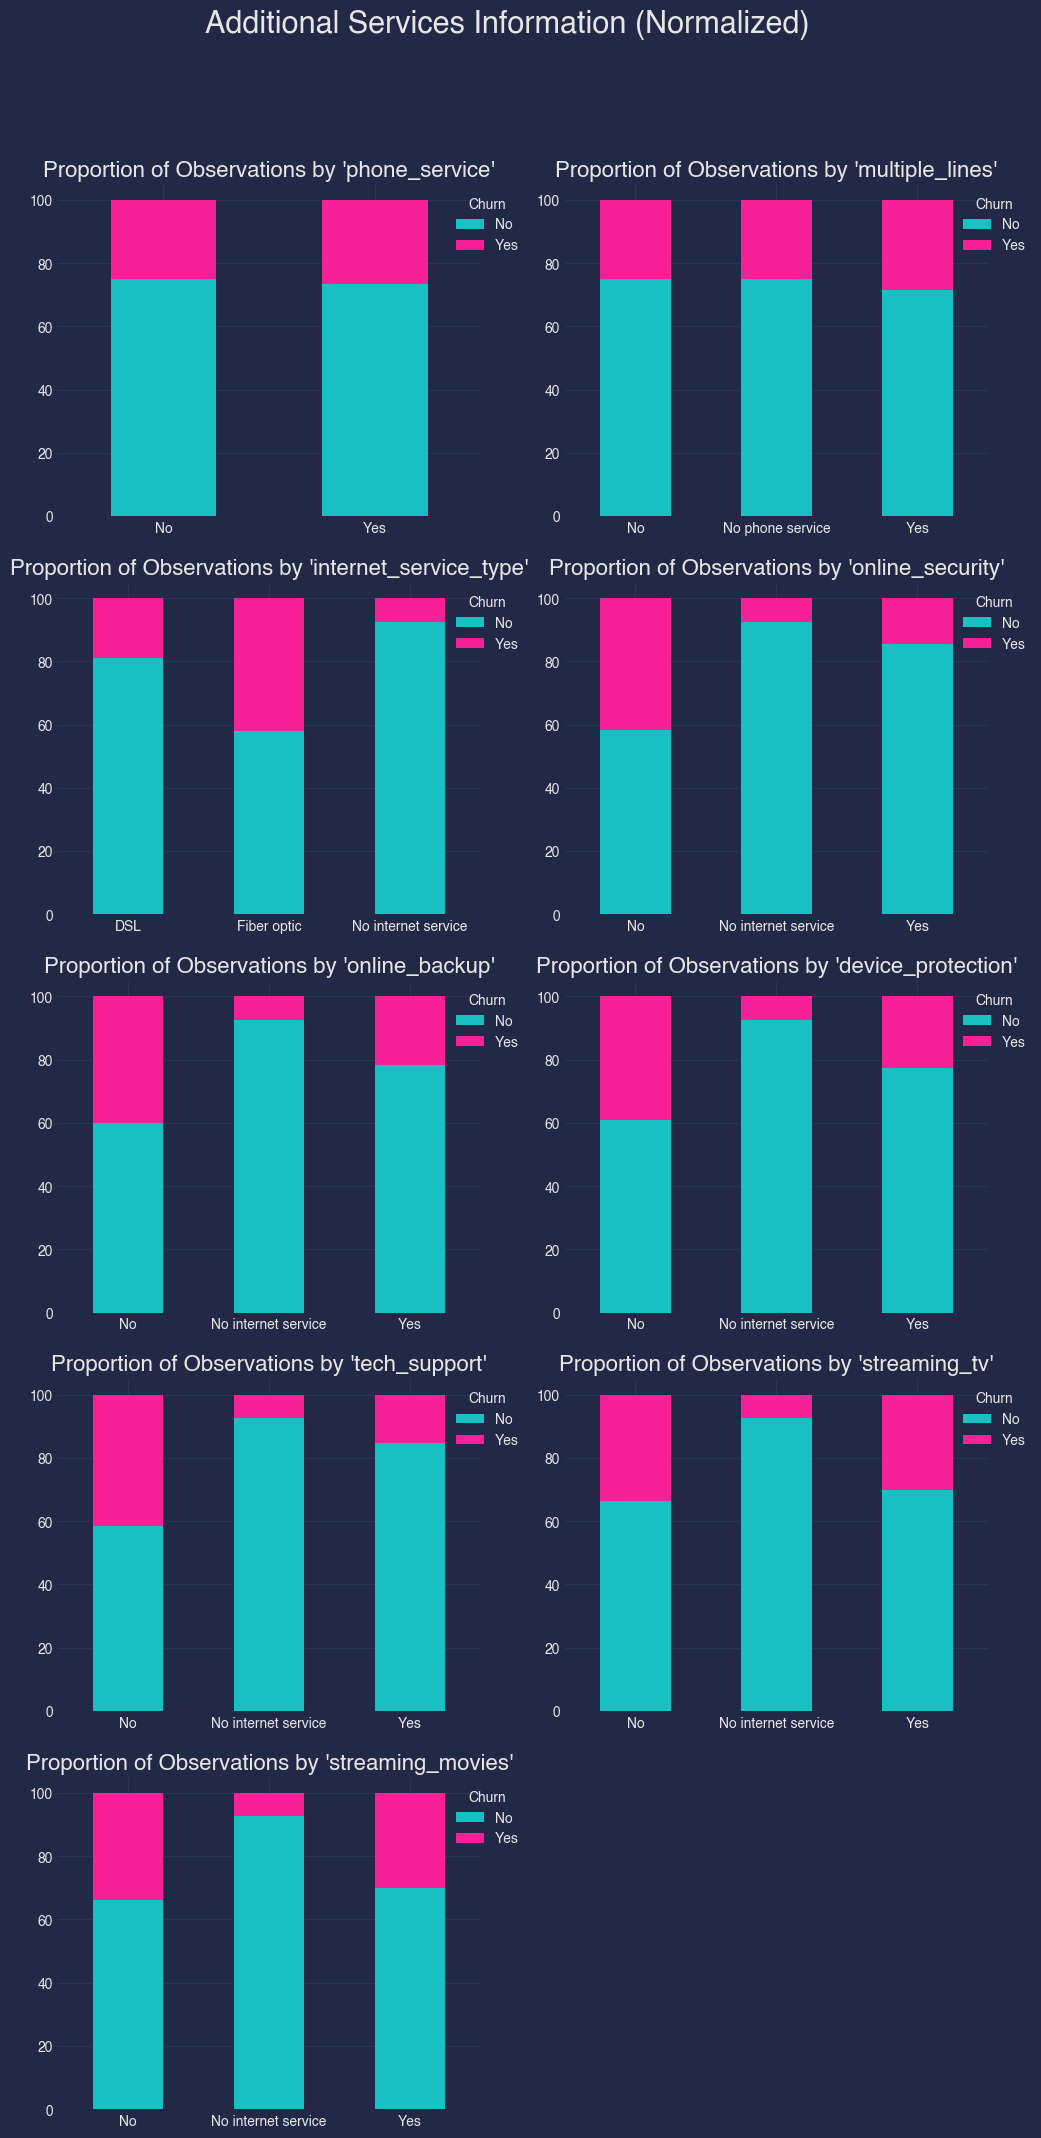

In [15]:
# services column names
services_columns = ['phone_service', 'multiple_lines', 'internet_service_type', 'online_security',
                   'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']

# stacked plot of services columns
percentage_stacked_plot(services_columns, 'Additional Services Information (Normalized)')

- We do not expect phone attributes (PhoneService and MultipleLines) to have significant predictive power. The percentage of churn for all classes in both independent variables is nearly the same.

- Clients with online security churn less than those without it.

- Customers with no tech support tend to churn more often than those with tech support.

## Make Binary & Splits

### Binary

In [16]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def telco_binary_normalized(df_telco):
        '''
        This function takes in a dataframe and returns a modified dataframe with binary values for certain columns and one-hot encoded values for categorical columns.
        
        Parameters:
        -----------
        df_telco : pandas dataframe
                The dataframe to be modified.
        
        Returns:
        --------
        df_telco : pandas dataframe
                The modified dataframe with binary values for certain columns and one-hot encoded values for categorical columns.
        '''
        df_telco.replace({
                        'No internet service': 0,
                        'No phone service': 0,
                        'No': 0,
                        'Yes': 1,
                        'Male': 1, 
                        'Female': 0}, inplace=True)
                
        # 3 Categories (but we want to keep all 3, rather than keeping the original column)
        categorical = ['contract_type', 'payment_type', 'internet_service_type']

        cat = pd.get_dummies(df_telco[categorical], drop_first=False, dtype='int')

        # Rename for uniformity
        cat.rename(columns={'contract_type_Month-to-month':'month_to_month_contract',
                                                'contract_type_One year':'one_year_contract',
                                                'contract_type_Two year':'two_year_contact',
                                                'payment_type_bank transfer':'bank_transfer_payment',
                                                'payment_type_credit card':'credit_card_payment', 
                                                'payment_type_electronic check':'e_check_payment',
                                                'payment_type_mailed check':'mailed_check_payment',
                                                'internet_service_type_DSL':'dsl_internet',
                                                'internet_service_type_Fiber optic':'fiber_optic_internet'}
                        , inplace=True)

        df_telco = pd.concat([df_telco, cat], axis=1)
        
        # Drop columns that are now redundant after get_dummies
        df_telco.drop(columns=['internet_service_type_0', 'contract_type', 'internet_service_type', 'payment_type'], inplace=True)
        
        '''
        # min-max normalization (numeric variables)
        normalize_columns = ['tenure_months', 'monthly_charges', 'total_charges', 'total_add_ons', 'tenure_years']

        # scale numerical variables using min max scaler
        for column in normalize_columns:
                # minimum value of the column
                min_column = df_telco[column].min()
                # maximum value of the column
                max_column = df_telco[column].max()
                # min max scaler
                df_telco[column] = (df_telco[column] - min_column) / (max_column - min_column)
        '''
        # Scale the non-binary numerical columns for normalization in the ML models
        
        # create a MinMaxScaler object
        scaler = MinMaxScaler()

        # select the columns to scale
        cols_to_scale = ['tenure_months', 'monthly_charges', 'total_charges', 'total_add_ons', 'tenure_years']

        # fit the scaler to the selected columns
        scaler.fit(df_telco[cols_to_scale])

        # transform the selected columns
        df_telco[cols_to_scale] = scaler.transform(df_telco[cols_to_scale])
        return df_telco


In [17]:
telco_ml = telco_binary_normalized(df_telco)

In [18]:
telco_ml

,gender,senior_citizen,married,kids,tenure_months,phone_service,multiple_lines,online_security,online_backup,device_protection,...,total_add_ons,month_to_month_contract,one_year_contract,two_year_contact,bank_transfer_payment,credit_card_payment,e_check_payment,mailed_check_payment,dsl_internet,fiber_optic_internet
customer_id,,,,,,,,,,,,,,,,,,,,,
0002-ORFBO,0,0,1,1,0.125000,1,0,0,1,0,...,0.571429,0,1,0,0,0,0,1,1,0
0003-MKNFE,1,0,0,0,0.125000,1,1,0,0,0,...,0.285714,1,0,0,0,0,0,1,1,0
0004-TLHLJ,1,0,0,0,0.055556,1,0,0,0,1,...,0.285714,1,0,0,0,0,1,0,0,1
0011-IGKFF,1,1,1,0,0.180556,1,0,0,1,1,...,0.714286,1,0,0,0,0,1,0,0,1
0013-EXCHZ,0,1,1,0,0.041667,1,0,0,0,0,...,0.428571,1,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9987-LUTYD,0,0,0,0,0.180556,1,0,1,0,0,...,0.428571,0,1,0,0,0,0,1,1,0
9992-RRAMN,1,0,1,0,0.305556,1,1,0,0,0,...,0.285714,1,0,0,0,0,1,0,0,1
9992-UJOEL,1,0,0,0,0.027778,1,0,0,1,0,...,0.285714,1,0,0,0,0,0,1,1,0


In [19]:
check_columns(telco_ml)

gender (2)
Unique Values: [0 1]
Null Values: 0

senior_citizen (2)
Unique Values: [0 1]
Null Values: 0

married (2)
Unique Values: [1 0]
Null Values: 0

kids (2)
Unique Values: [1 0]
Null Values: 0

tenure_months (73)
Unique Values: [0.125      0.05555556 0.18055556 0.04166667 0.98611111 0.875
 0.09722222 0.90277778 0.75       1.         0.06944444 0.77777778
 0.47222222 0.01388889 0.625      0.69444444 0.31944444 0.76388889
 0.36111111 0.95833333 0.51388889 0.68055556 0.91666667 0.93055556
 0.27777778 0.59722222 0.81944444 0.16666667 0.375      0.02777778
 0.34722222 0.40277778 0.19444444 0.48611111 0.88888889 0.54166667
 0.55555556 0.15277778 0.08333333 0.41666667 0.97222222 0.79166667
 0.80555556 0.22222222 0.44444444 0.45833333 0.13888889 0.29166667
 0.84722222 0.20833333 0.61111111 0.30555556 0.33333333 0.26388889
 0.65277778 0.86111111 0.63888889 0.72222222 0.11111111 0.83333333
 0.66666667 0.38888889 0.56944444 0.73611111 0.94444444 0.43055556
 0.5        0.23611111 0.25       0

### Split

In [20]:
from sklearn.model_selection import train_test_split

def split_telco(df):
    """
    take in a DataFrame and return train, validate, and test DataFrames; stratify on a specified variable.
    return train, validate, test DataFrames.
    """
    train_validate, test = train_test_split(
        df, test_size=0.2, random_state=123, stratify=df['churn']
    )
    train, validate = train_test_split(
        train_validate, test_size=0.3, random_state=123, stratify=train_validate['churn']
    )
    print(f"train: {len(train)} ({round(len(train)/len(df), 2)*100}% of {len(df)})")
    print(f"validate: {len(validate)} ({round(len(validate)/len(df), 2)*100}% of {len(df)})")
    print(f"test: {len(test)} ({round(len(test)/len(df), 2)*100}% of {len(df)})")
    
    return train, validate, test

### X, Y Splits

In [21]:
train, validate, test = split_telco(telco_ml)

train: 3943 (56.00000000000001% of 7043)
validate: 1691 (24.0% of 7043)
test: 1409 (20.0% of 7043)


In [22]:
# Create X & y version of train, validate, test where y is a series with just the target variable and X are all the features. 

# We'll do exploration and train our model on the train data
X_train = train.drop(columns=['churn'])
y_train = train['churn']

# We tune our model on validate, since it will be out-of-sample until we use it. 
X_validate = validate.drop(columns=['churn'])
y_validate = validate['churn']

# Keep the test separate, for our final out-of-sample dataset, to see how well our tuned model performs on new data.
X_test = test.drop(columns=['churn'])
y_test = test['churn']

### Establish Baseline

In [23]:
# Models need to outperform the baseline (73% to be considered for future predictions)

print(f'Baseline: {round(telco_ml["churn"].value_counts(normalize=True), 2)[0] * 100}%')

Baseline: 73.0%


In [24]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

def create_models(seed=123):
    '''
    Create a list of machine learning models.
            Parameters:
                    seed (integer): random seed of the models
            Returns:
                    models (list): list containing the models
    '''

    models = []

    models.append((KNeighborsClassifier(n_neighbors=5)))
    models.append((LogisticRegression(random_state=seed)))
    models.append((RandomForestClassifier(max_depth=5, min_samples_leaf=3, random_state=seed)))
    models.append((DecisionTreeClassifier(max_depth=5, random_state=seed)))
    
    return models

# create a list with all the algorithms we are going to assess
models = create_models()

# convert the models list to a DataFrame
models_df = pd.DataFrame(models, columns=['Model Object & Parameters'])

# print the DataFrame
print(models_df)

                           Model Object & Parameters
0                             KNeighborsClassifier()
1               LogisticRegression(random_state=123)
2  RandomForestClassifier(max_depth=5, min_sample...
3  DecisionTreeClassifier(max_depth=5, random_sta...


In [30]:
from sklearn.metrics import accuracy_score

# test the accuracy of each model using default hyperparameters
results = []
names = []
scoring = 'accuracy'
for model in models:
    # fit the model with the training data
    model.fit(X_train, y_train).predict(X_test)
    # make predictions with the testing data
    predictions = model.predict(X_test)
    # calculate accuracy 
    accuracy = accuracy_score(y_test, predictions)
    # append the model name and the accuracy to the lists
    results.append(accuracy)
    # print classifier accuracy
    print(f'Model & Parameters: {model}, Accuracy: {round(accuracy,2)})')

Model & Parameters: KNeighborsClassifier(), Accuracy: 0.76)
Model & Parameters: LogisticRegression(random_state=123), Accuracy: 0.82)
Model & Parameters: RandomForestClassifier(max_depth=5, min_samples_leaf=3, random_state=123), Accuracy: 0.8)
Model & Parameters: DecisionTreeClassifier(max_depth=5, random_state=123), Accuracy: 0.78)
